## Results of Host Prediction
### Dataset: Coronaviridae S prot UniRef90, EMBL mapping, Vertebrates

**Models**: TF - Pretrain  + finetune

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1336

**Alignment**: Yes, No

**Classification**: Multi-class

**\# classes**: 8, 2

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 


In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [3]:
! pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean

In [5]:
sns.__version__

'0.12.0'

In [6]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"

def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath=None):
    auprc_results = []
    classes = None
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = auprcs_df.append({"class": "Macro-AUPRC", "auprc": auprcs_df["auprc"].mean()}, ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    #metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class": metadata_formatted}, inplace=True)
    

    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=False, sharey=True, gridspec_kw={"width_ratios": [1, 4]})
    color_palette = sns.cubehelix_palette(start=1, rot=-.9, hue=1, dark=.35, light=.85, n_colors=auprc_results_df["model"].nunique())
    color_palette_green = sns.cubehelix_palette(start=2, light=0.8, rot=1, dark=.9, n_colors=auprc_results_df["model"].nunique())
#     ax = sns.violinplot(data=auprc_results_df, x="class", y="auprc", hue="model", orient="v", inner="quart",
#                        split=False, bw_adjust=0.08, bw_method="scott", dodge=True, cut=2, scale="area",
#                        saturation=0.75, order=metadata_sorted, palette=color_palette)
    print(auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())].shape)
    print(auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"].shape)
#     sns.barplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="class", y="auprc", hue="model", fill=True,
#                 orient="v", palette=color_palette, legend=False, ax=axs[0],
#                 errorbar=None, linewidth=1.5, edgecolor="0")
    sns.violinplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="class", y="auprc", hue="model", fill=True,
                orient="v", palette=color_palette, legend=False, ax=axs[0])
#     for i in axs[0].containers:
#         axs[0].bar_label(i, fontsize=18, fmt="%.2f")
    sns.barplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", orient="v", order=metadata_sorted, palette=color_palette, ax=axs[1], legend="auto")
    #sns.violinplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", orient="v", order=metadata_sorted, palette=color_palette, ax=axs[1], legend="auto")
    plt.draw()
    
    axs[0].set_ylim(0.2, 1)
    axs[1].set_ylim(0.2, 1)
    axs[0].set_ylabel("AUPRC", size=20)
    axs[0].set_xlabel("", size=20, labelpad=0)
    axs[1].set_xlabel("", size=20, labelpad=0)
    sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.45, 1), ncol=5, title=None, frameon=False)
    plt.setp(axs[1].get_legend().get_texts(), fontsize=20)
    visualization_utils.wrap_ticklabels(axs[0], axis="x")
    visualization_utils.wrap_ticklabels(axs[1], axis="x")
    
    plt.subplots_adjust(wspace=0.05)
    #plt.tight_layout()
    visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df


### UniProt

In [9]:
file_paths = {
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_224530.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241114/host_multi/external/uniprot_coronaviridae_prostt5_msl2048_bn_fnn_2l_d1024_lr3e-4_output.csv"),
    
    #"ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_132840.csv"),
    #"VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240326/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniprot_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "ESM2": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241118/host_multi/external/uniprot_coronaviridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240909/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-5_output.csv"),
#     "VirProBERT3e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241117/host_multi/virprobert/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr3e-4_output.csv"),
    
}


classes = ["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

Read output ProstT5 = (1785, 10)
Read output ESM2 = (1785, 10)
Read output VirProBERT = (1785, 10)
(120, 4)
(15, 4)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../src/utils/visualization_utils.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0)


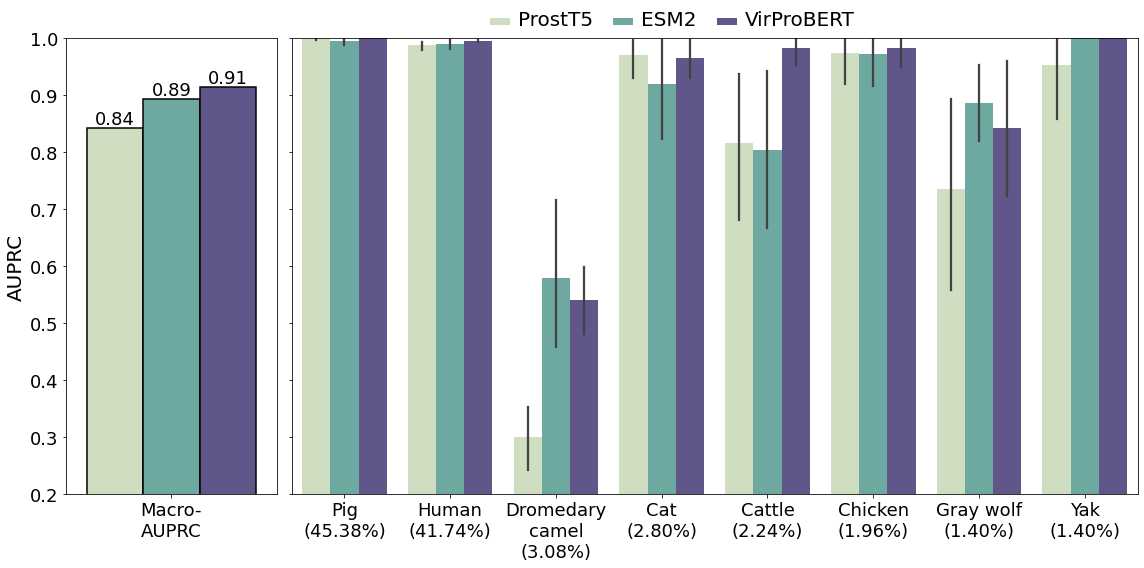

,class,auprc,model,itr
0,Human (41.74%),0.995812,ProstT5,0
1,Cat (2.80%),0.985431,ProstT5,0
2,Pig (45.38%),0.996679,ProstT5,0
3,Chicken (1.96%),1.000000,ProstT5,0
4,Yak (1.40%),1.000000,ProstT5,0
...,...,...,...,...
130,Yak (1.40%),1.000000,VirProBERT,4
131,Cattle (2.24%),1.000000,VirProBERT,4
132,Gray wolf (1.40%),0.776667,VirProBERT,4
133,Dromedary camel (3.08%),0.642265,VirProBERT,4


In [7]:
class_wise_auprc_analysis(file_paths, classes, 
                          figure_output_filepath=os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_cov_s_uniprot_auprc_barplot.pdf"))

### UniRef90

In [7]:

file_paths = {
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_222843.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241114/host_multi/external/uniref90coronaviridae_prostt5_msl2048_bn_fnn_2l_d1024_lr3e-4_output.csv"),
    "ESM2": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241118/host_multi/external/uniref90coronaviridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_140312.csv"),
    #"VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240320/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniref90_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240909/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-5_output.csv"),
#     "VirProBERT3e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241117/host_multi/virprobert/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr3e-4_output.csv"),
}

classes = ["Chicken", "Human", "Cat", "Pig", "Gray wolf", "Horshoe bat", "Ferret", "Chinese rufous horseshoe bat"]

Read output ProstT5 = (345, 10)
Read output ESM2 = (345, 10)
Read output VirProBERT = (345, 10)
(120, 4)
(15, 4)


AttributeError: 'Rectangle' object has no property 'legend'

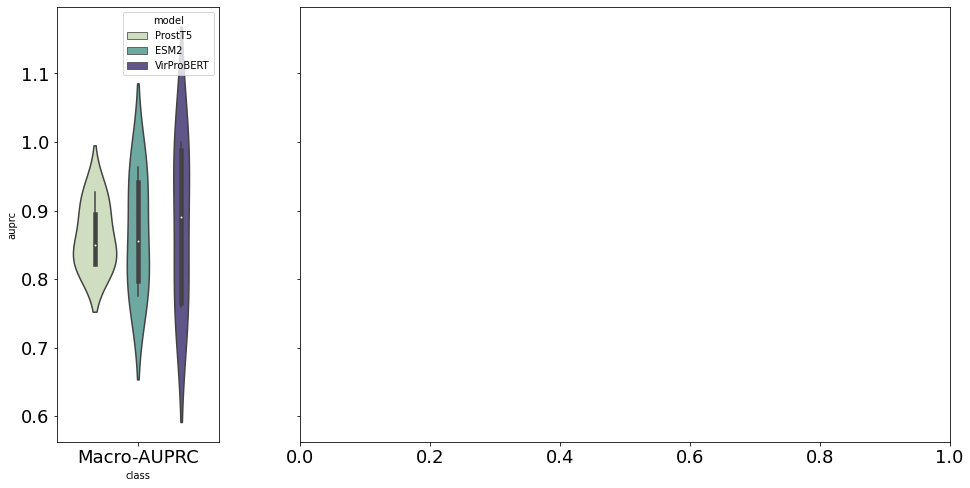

In [8]:
class_wise_auprc_analysis(file_paths, classes,
                         figure_output_filepath=os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_cov_s_uniref90_auprc_barplot.pdf"))